In [27]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# import timeit
from scipy.integrate import odeint
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# c = lambda t: 2+2*t/256+np.sin(t)
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)

In [91]:
nyears = 1

settlingTime = 2**11
tlen = 2 ** 7
end = 2**3*tlen # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 8
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 0
# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# 
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [117]:
""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
# x0 = np.array([0.49])
# x0 = np.array([0.1,0.4,9])
x0 = np.array([1,5,9],dtype=float)

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
# r = lambda t: 4 # - t / tlen
b1 = lambda t: 4.5 + 1.5*np.cos(np.pi*t/end) # 6.5 - 4.5*np.heaviside(t-end/2,0)

""" GENERATE TS """
Xr = generateTimeSeriesContinuous("HastingsPowell", x0, tlen=2**7, end=2**9, reduction=64, settlingTime=2**10)[:,0,None]
# Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
# Xr = Xc[:,1,None]
# Xr = generateTimeSeriesDiscrete(LogisticP, x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)

In [118]:
print(tr.shape, Xr.shape)

(128,) (128, 1)


In [119]:
"""
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(Xc[:,1], Xc[:,0])
ax.set_xlabel("Juveniles")
ax.set_ylabel("Adults")

# ax[1].plot(Xr[::5,1])
# ax[1].set_ylabel("Juveniles")
# ax[2].plot(Xr[::5,0])
# ax[2].set_ylabel("Adults")
plt.tight_layout()
plt.show()
"""

'\nfig, ax = plt.subplots(1, figsize=(6,4))\nax.scatter(Xc[:,1], Xc[:,0])\nax.set_xlabel("Juveniles")\nax.set_ylabel("Adults")\n\n# ax[1].plot(Xr[::5,1])\n# ax[1].set_ylabel("Juveniles")\n# ax[2].plot(Xr[::5,0])\n# ax[2].set_ylabel("Adults")\nplt.tight_layout()\nplt.show()\n'

In [120]:
# poincareT(Xc[:,1],xlabel="Juveniles(t)", ylabel="Juveniles(t-1)")

In [121]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""
# END FROM DATA

'\nfile = "GPDD.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nstates = data.to_numpy()\n\nXr = np.log(states[:,2,None]+1)\ntr = states[:,3] - np.min(states[:,3])\ntlen = states.shape[0]\n'

In [122]:

""" UPDATE DRIVERS HERE """

digiDrivers = [b1]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
gtsr = b1(t) # driverArray
# gtsr = c(t)

<IPython.core.display.Javascript object>


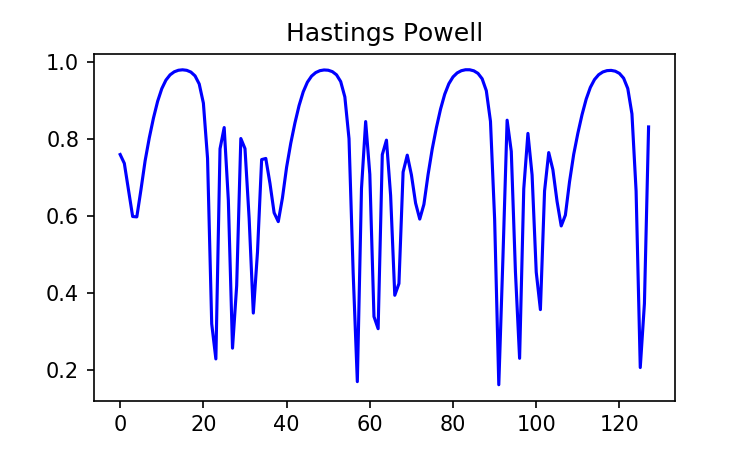

In [123]:
fig2 = plt.figure(2,figsize=(5,3))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    
ax2.set_title("Hastings Powell")
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

<IPython.core.display.Javascript object>


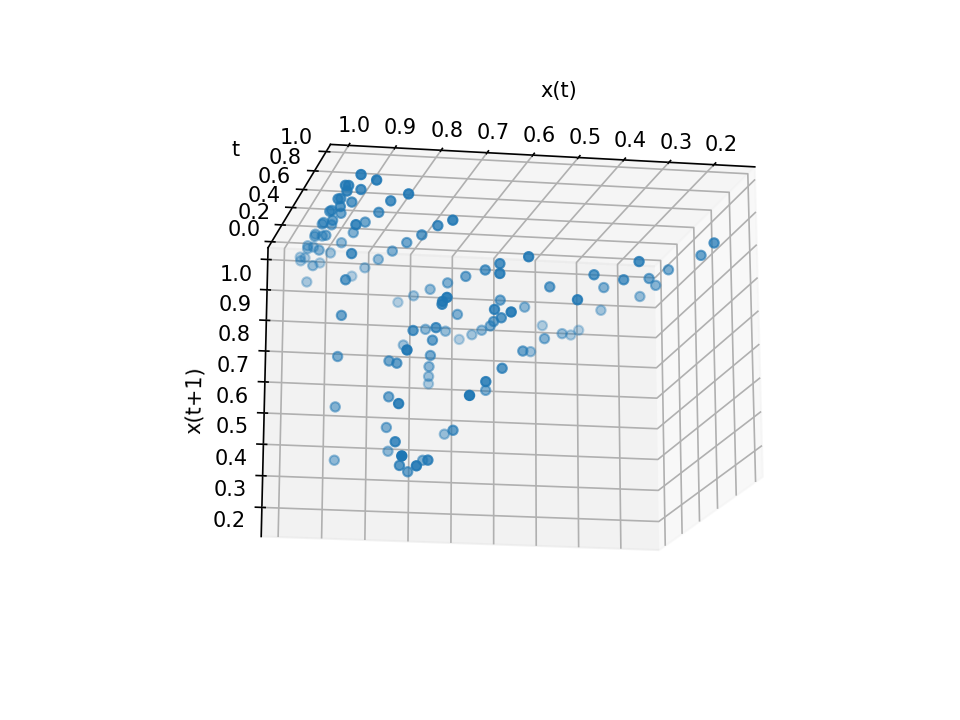

In [99]:
poincareT(Xr)

<IPython.core.display.Javascript object>


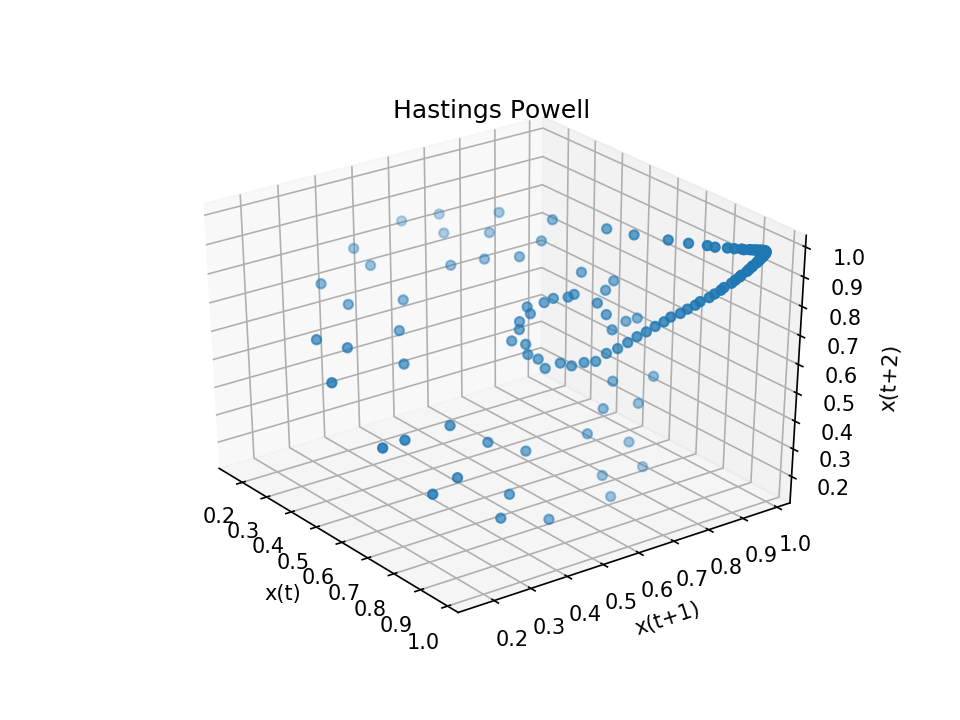

In [124]:
poincare3d(Xr, title="Hastings Powell")

<IPython.core.display.Javascript object>


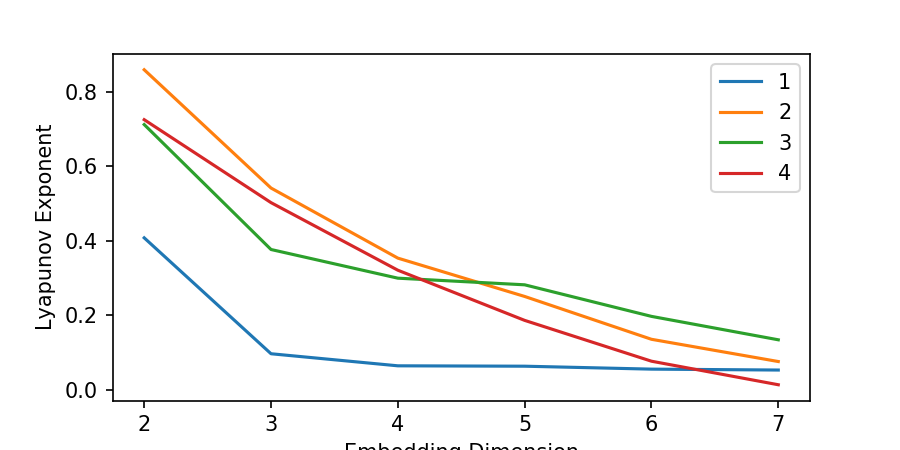

In [142]:
FNNplot(Xr, 5, 4)

In [102]:
predictionHorizon = 1
numLags = 1
lagStep = 1
maxLags = 5

nHPvals = 15

thetaVals = np.linspace(1, 100, num=nHPvals)
deltaVals = np.linspace(0, 1, num=nHPvals)

In [189]:
thetaBestNS, deltaBestNS, lagBestNS, errorNS, landNS = NSMapOptimize(Xr, tr, predictionHorizon, maxLags, lagStep, thetaVals, deltaVals, returnLandscape=True)
thetaBestS, lagBestS, errorS, landS = SMapOptimize(Xr, tr, predictionHorizon,maxLags,lagStep, thetaVals, returnLandscape=True)

In [190]:
thetaBestS, lagBestS, errorS, landS = SMapOptimize(Xr, tr, predictionHorizon,maxLags,lagStep, thetaVals, returnLandscape=True)

In [191]:
print(f"NSMap -- theta: {thetaBestNS}, delta: {deltaBestNS}, Min Error: {errorNS}, Optimal Embedding Dimension: {lagBestNS+2}")
print(f"SMap -- theta: {thetaBestS}, Min Error: {errorS}, Optimal Embedding Dimension:{lagBestS+2}")

print("Improvement of NSMap: ", errorS/errorNS)

NSMap -- theta: 15.142857142857142, delta: 0.99, Min Error: 1.0267246468041875, Optimal Embedding Dimension: 6
SMap -- theta: 15.142857142857142, Min Error: 0.7061537194485121, Optimal Embedding Dimension:4
Improvement of NSMap:  0.687773222982916


In [192]:
""" COMPUTE DOFS """

Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagBestNS, lagStep, t=t)
dofNS = dofestimation(Xn, Yn, txn, thetaBestNS, deltaBestNS)

Xs, Ys, txs = delayEmbed(Xr, predictionHorizon, lagBestS, lagStep, t=t)
dofS = dofestimation(Xs, Ys, txs, thetaBestS, 1)

print(f"NSMap dof: {dofNS}")
print(f"SMap dof: {dofS}")

NSMap dof: 103.3431544052626
SMap dof: 93.8209581172552


In [193]:
AkaikeTest(errorNS, errorS, dofNS, dofS, Xr.shape[0])

Probability NSMap beats SMap:  2.8910763314373613e-15


In [194]:
predictedTSNS = leaveOneOut(Xn, Yn, txn, thetaBestNS, deltaBestNS)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaBestS, 1)

<IPython.core.display.Javascript object>


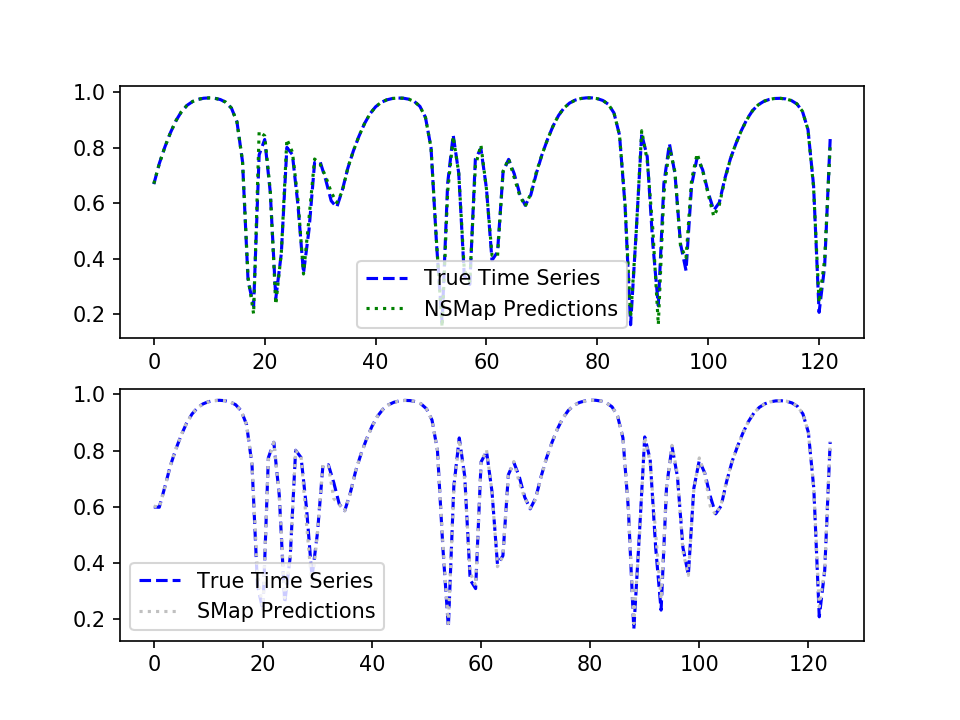

In [195]:
figLOU, axLOU = plt.subplots(2)
axLOU[0].plot(Yn, c="blue", linestyle="dashed", label="True Time Series")
axLOU[0].plot(predictedTSNS, c="green", linestyle="dotted", label="NSMap Predictions")
axLOU[0].legend()

axLOU[1].plot(Ys, c="blue", linestyle="dashed", label="True Time Series")
axLOU[1].plot(predictedTSS, c="silver", linestyle="dotted", label="SMap Predictions")
axLOU[1].legend()
plt.show()

<IPython.core.display.Javascript object>


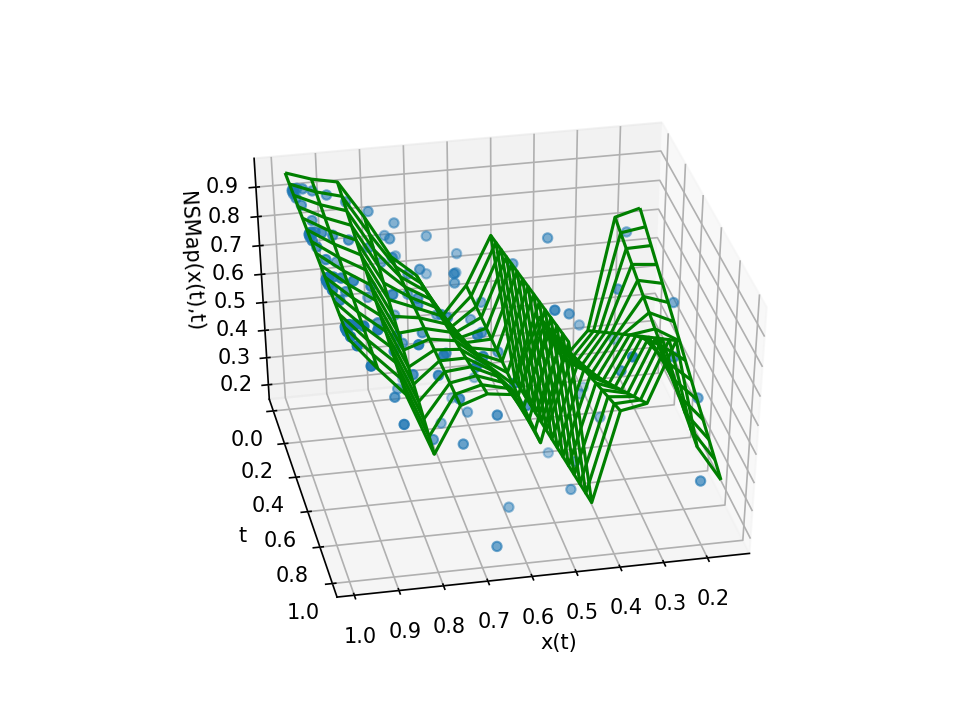

In [176]:
functionSurfaceNSMap(Xr, predictionHorizon, thetaBestNS, deltaBestNS, 15)

<IPython.core.display.Javascript object>


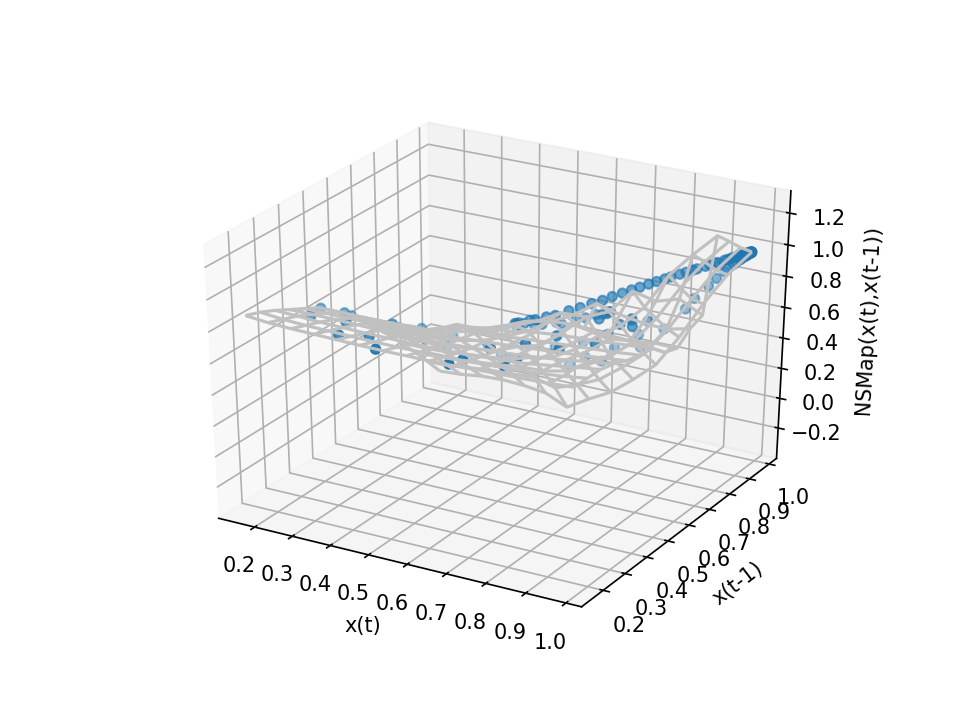

In [187]:
functionSurfaceSMap(Xr, predictionHorizon, thetaBestS, 15)

In [188]:
### SUMMARY ###

print(f"NSMap -- theta: {thetaBestNS:.3f}, delta: {deltaBestNS:.3f}, Min Error: {errorNS:.3f}, Optimal Embedding Dimension: {lagBestNS+2}")
print(f"SMap -- theta: {thetaBestS:.3f}, Min Error: {errorS:.3f}, Optimal Embedding Dimension: {lagBestS+2}")

print(f"Improvement of NSMap: {errorS/errorNS:.3f}")

print(f"NSMap dof: {dofNS:.3f}")
print(f"SMap dof: {dofS:.3f}")

AkaikeTest(errorNS, errorS, dofNS, dofS, Xr.shape[0])

NSMap -- theta: 15.143, delta: 0.990, Min Error: 1.027, Optimal Embedding Dimension: 6
SMap -- theta: 15.143, Min Error: 0.706, Optimal Embedding Dimension: 4
Improvement of NSMap: 0.688
NSMap dof: 103.343
SMap dof: 93.821
Probability NSMap beats SMap:  2.8910763314373613e-15


In [179]:
landNS[:,:,1].shape

(15, 15)

<IPython.core.display.Javascript object>


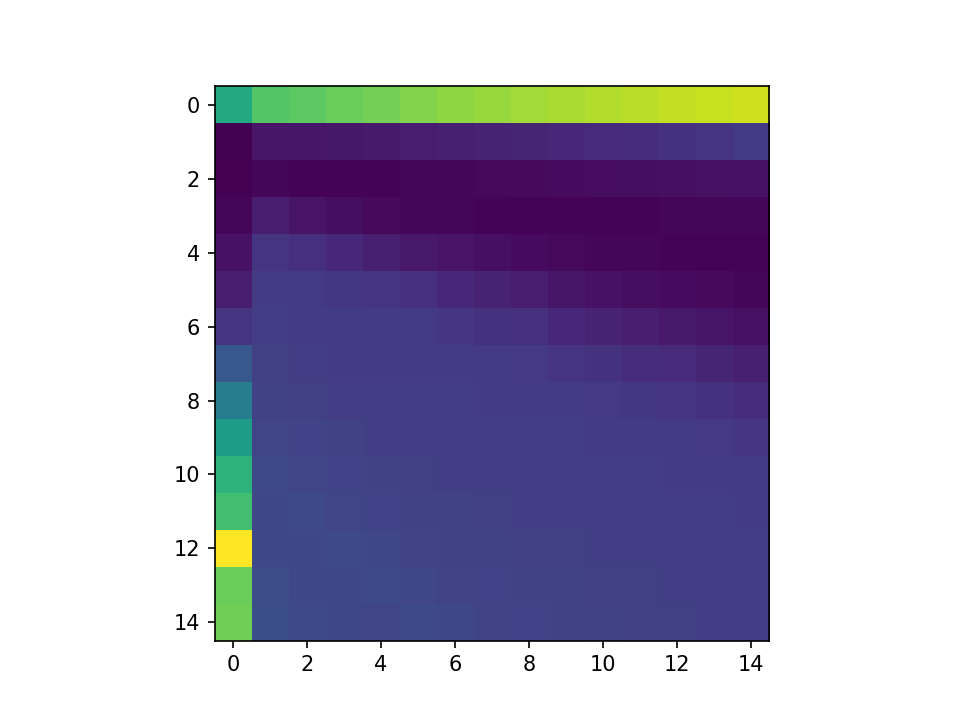

In [136]:
fix, ax = plt.subplots(1)
ax.imshow(landNS[:,:,4])